In [521]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow import one_hot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Data Prepocessing

## Loading

In [522]:
repub = pd.read_excel(r"Data\training_sample\repub_sample.xls")[['text','sentiment']].rename(columns={'sentiment': "labels", "text":"data"})
repub['labels_n'] = repub['labels']+1
df = repub[['data', 'labels_n']]
print('data shape:', df.shape)
df.head()

data shape: (1699, 2)


,data,labels_n
0,@realDonaldTrump @GOP Murkowski changes her mi...,0
1,@BlackVoices4DJT Volunteers have a message for...,2
2,"“The Boat”, 2020:\nDuring a Trump rally, sever...",1
3,RT @authorbtwomey: #RIPRBG The #democrats bega...,1
4,Top House #Republican @GOPLeader advises voter...,1


In [523]:
clear_text = [str(df.data.iloc[i]).replace('#', '') for i in range(len(df.data))]
clear_text = [str(clear_text[i]).replace(r"*", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"'", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"&amp;", ' and ') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).lower() for i in range(len(clear_text))]
(print(clear_text[5]))

rt @hopeandrespect: hope 128
"when he leaves office the united states will be something akin to a recovering drug addict in a 12 step prog…


In [524]:
porter = PorterStemmer()
def stemsentence(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
text_stemmed = [stemsentence(txt) for txt in clear_text]
print(text_stemmed[5])

rt @ hopeandrespect : hope 128 '' when he leav offic the unit state will be someth akin to a recov drug addict in a 12 step prog… 


In [525]:
df['ready_data'] = text_stemmed
df.shape

(1699, 3)

In [526]:
Y = np.array(one_hot(df.labels_n, depth=3))
print('Y=',Y[:10])
print('number of missing values:',np.isnan(Y).sum())

Y= [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
number of missing values: 0


## Train-test split

In [527]:
df_train, df_test, Y_train, Y_test = train_test_split(df.ready_data, Y, test_size=0.25)

## Tokenizing tweet texts

In [528]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [529]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 5317 unique tokens.


## Padding sequences to the same length

In [530]:
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

T = data_train.shape[1]

Shape of data train tensor: (1274, 79)


In [531]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (425, 79)


## Class weights to use in the model

In [532]:
neg = (Y_train[:,0] == 1).sum()
neu = (Y_train[:,1] == 1).sum()
pos = (Y_train[:,2] == 1).sum()
total = len(Y_train)

print("neg:", neg/total)
print("neu:", neu/total)
print("pos:", pos/total)
weight_for_0 = (1/neg)*(total)/3
weight_for_1 = (1/neu)*(total)/3
weight_for_2 = (1/pos)*(total)/3

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
print(class_weight)

neg: 0.3893249607535322
neu: 0.4638932496075353
pos: 0.14678178963893249
{0: 0.8561827956989246, 1: 0.7185561195713479, 2: 2.270944741532977}


# RNN (LSTM) Model

## Creating the model

In [533]:
D = 20
M = 15

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training model...")

r = model.fit(data_train, Y_train, epochs=10, class_weight=class_weight, batch_size=32, validation_data=(data_test, Y_test))

Training model...
Epoch 1/10
40/40 [==============================] - 2s 46ms/step - loss: 1.0963 - accuracy: 0.4262 - val_loss: 1.0931 - val_accuracy: 0.4918
Epoch 2/10
40/40 [==============================] - 1s 37ms/step - loss: 1.0715 - accuracy: 0.5785 - val_loss: 1.0608 - val_accuracy: 0.5953
Epoch 3/10
40/40 [==============================] - 1s 33ms/step - loss: 0.9677 - accuracy: 0.7135 - val_loss: 0.9446 - val_accuracy: 0.6588
Epoch 4/10
40/40 [==============================] - 1s 34ms/step - loss: 0.7672 - accuracy: 0.8485 - val_loss: 0.8488 - val_accuracy: 0.6965
Epoch 5/10
40/40 [==============================] - 1s 37ms/step - loss: 0.5910 - accuracy: 0.8430 - val_loss: 0.8214 - val_accuracy: 0.6988
Epoch 6/10
40/40 [==============================] - 1s 34ms/step - loss: 0.4634 - accuracy: 0.9184 - val_loss: 0.8179 - val_accuracy: 0.7271
Epoch 7/10
40/40 [==============================] - 1s 34ms/step - loss: 0.3464 - accuracy: 0.9498 - val_loss: 0.7807 - val_accuracy: 0.

In [546]:
model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 79)]              0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 79, 20)            106360    
_________________________________________________________________
lstm_25 (LSTM)               (None, 79, 15)            2160      
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 15)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 48        
Total params: 108,568
Trainable params: 108,568
Non-trainable params: 0
_________________________________________________________________


## Log-likelihood and accuracy per iteration

In [534]:
N = Y_train.shape[0]

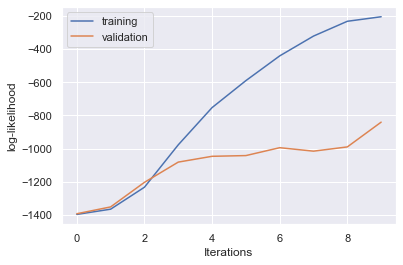

In [535]:
plt.plot(-np.array(r.history['loss'])*N, label='training')
plt.plot(-np.array(r.history['val_loss'])*N, label='validation')
plt.ylabel('log-likelihood')
plt.xlabel('Iterations')
plt.legend()

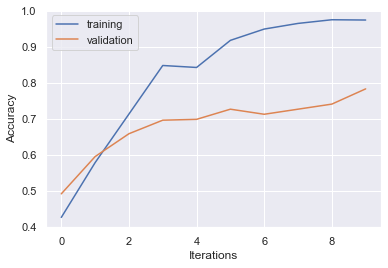

In [536]:
plt.plot(r.history['accuracy'], label='training')
plt.plot(r.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()

## Confusion Matrix

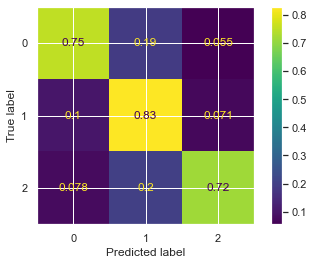

In [537]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict(data_test)
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), normalize='true')
ConfusionMatrixDisplay(matrix).plot()

# Prediction of sentiment values for the rest of tweets

## Loading the new data

In [54]:
import os
filelist = os.listdir(r'Data\raw')
new_files = []
for f in filelist:
    if f.startswith('r'):
        new_files.append(f)
print(new_files)

['rep_09-07 - 09-21.pickle', 'rep_09-22 - 10-13.pickle', 'rep_10-12 - 10-26.pickle']


In [55]:
df_list = [pd.read_pickle('Data\\raw\\'+new_files[i]) for i in range(3)]
for d in df_list:
    if 'text' not in d.columns:
        d['text'] = d['full_text']
        d['retweeted_status-text'] = d['retweeted_status-full_text']
df_new = pd.concat(df_list)[['text', 'retweeted_status-text']].reset_index()
for t in df_new.index:
    if df_new.loc[t, 'text'].startswith('RT'):
        df_new.loc[t, 'text'] = df_new.loc[t, 'retweeted_status-text']


## Same preprocessing

In [538]:
clear_text = [str(df_new.text.iloc[i]).replace('#', '') for i in range(len(df_new.text))]
clear_text = [str(clear_text[i]).replace(r"*", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"'", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"&amp;", ' and ') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).lower() for i in range(len(clear_text))]
text_stemmed = [stemsentence(txt) for txt in clear_text]
print(text_stemmed[5])

blue state governor still have their state on full or partial lockdown drive the unemploy . if your unemp… http : //t.co/uu7wx01rhm 


In [539]:
df_new['ready_data'] = text_stemmed
sequences_new = tokenizer.texts_to_sequences(df_new.ready_data)
data_new = pad_sequences(sequences_new, maxlen=T)

## Predicting values

In [540]:
predictions = np.argmax(model.predict(data_new),axis=1)

In [541]:
print("NEW DATA", "\n", "neg: ",(predictions==0).sum()/predictions.shape[0],"\n" "neut: ",(predictions==1).sum()/predictions.shape[0],"\n", "pos: ",(predictions==2).sum()/predictions.shape[0])

NEW DATA 
 neg:  0.19960646135542032 
neut:  0.7322259338916091 
 pos:  0.06816760475297061


In [542]:
output_df = pd.concat(df_list).reset_index()
output_df['sentiment'] = predictions-1

In [543]:
output_df.sentiment.value_counts()

 0    48004
-1    13086
 1     4469
Name: sentiment, dtype: int64

## Saving new file

In [544]:
#output_df.to_pickle(r'Data\classified_tweets\repub_classified.pickle')